# Autoregressive models

An **autoregressive** model expresses the value of a time series as a linear combination of prior values plus an error term.

## What we will accomplish:
* Define an $\operatorname{AR}(p)$ model:  an autoregressive process of order $p$.
* Look at the $\operatorname{AR}(1)$ and $\operatorname{AR}(2)$ special cases more closely.
* Discuss how to use a partial autocorrelation plot to select $p$.

## The $\operatorname{AR}(p)$ model.

The $\operatorname{AR}(p)$ model is

$$
y_t = \beta_1 y_{t-1} + \beta_2 y_{t-2} + \dots  + \beta_p y_{t - p} + \epsilon_t
$$

where $\epsilon_t \sim \operatorname{NID}(0,\sigma^2)$

$p$ is a hyperparameter and the $\beta_i$ and $\sigma^2$ are parameters which need to be fit.  We will not dive into *how* these parameters are fit in this bootcamp.

Our focus will be on understanding the model and selecting $p$.

We will start by understanding the $\operatorname{AR}(1)$ and $\operatorname{AR}(2)$ models.

## The $\operatorname{AR}(1)$ model

An $\operatorname{AR}(1)$ model is of the form:

$$
y_t = \beta y_{t-1} + \epsilon_t
$$

For this to be stationary we need $|\beta|<1$.  Note that $\beta = 1$ gives us a gaussian random walk.

Iteratively back substituting we get

$$
y_t = \beta^p y_{0} + \epsilon_t + \beta \epsilon_{t-1} + \beta^2 \epsilon_{t-2} + \beta^3 \epsilon_{t-3} + \dots + \beta^t \epsilon_{0}   
$$

This has a deterministic part which is exponential decay, plus a kind of "damped gaussian random walk" component.

Note that (using the sum of a geometric series)

$$
\begin{align*}
&\operatorname{var}\left(\epsilon_t + \beta \epsilon_{t-1} + \beta^2 \epsilon_{t-2} + \beta^3 \epsilon_{t-3} + \dots + \beta^t \epsilon_{0}\right)\\
&= (1 + \beta^2 + \beta^4 + \dots + \beta^{2t})\sigma^2\\
& =\frac{1 - \beta^{2(t+1)}}{1-\beta^2}\sigma^2
\end{align*}
$$

### Impulse Response interpretation

One nice way to interpret this model is by looking at the response to an "impulse" or "shock".

Say our model is 

$$y_t = \frac{1}{2} y_{t-1} + \epsilon_t$$

We are saying that each time step into the future we are getting half of the previous value plus some error.  This error will progate forward through time as $(\frac{1}{2})^{\Delta t} \epsilon_t$.  We will graph the response of $y_t$ to a unit error at time $0$ over time to get a feel for this:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

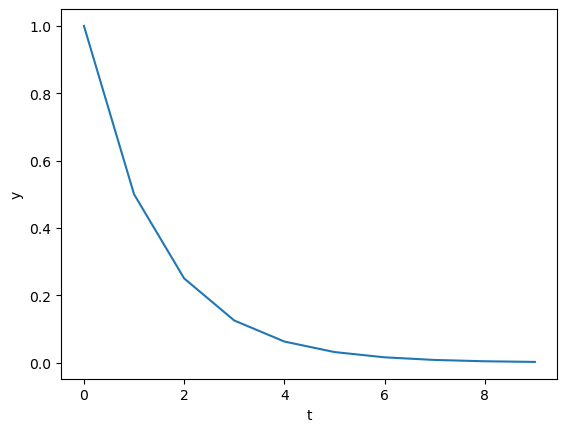

In [3]:
beta = 0.5
xs = range(10)
ys = [1]

for i in range(9):
    ys += [beta*ys[-1]]

plt.plot(xs,ys)
plt.xlabel("t")
plt.ylabel("y")
plt.show()

You can think of an $\operatorname{AR}(1)$ process as one where at each time period we experience a random "shock"  $\epsilon_t$. 

Each shock continues to contribute to the outcome at an exponentially decreasing weight over time.

The graph above shows the contribution of a single unit shock at time $0$ and how it contributes over time.

Let's look at some simulated data which is generated using $y_t = \frac{1}{2} y_{t-1} + \epsilon_t$

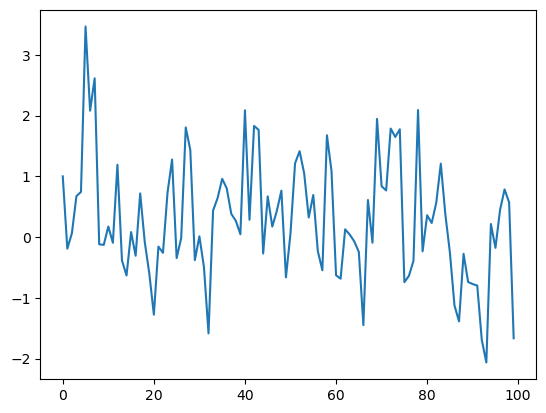

In [4]:
xs = range(100)
es = np.random.randn(100)
y = [1]
for i in range(99):
    y += [0.5*y[-1] + es[i]]

plt.plot(xs,y)
plt.show()

It is pretty hard to "see" the AR behavior from this graph.  Things get a little easier to see if we model it with a "large" shock.  The shock decays exponentially, and then we "settle down" to a series which looks similar to the one above.

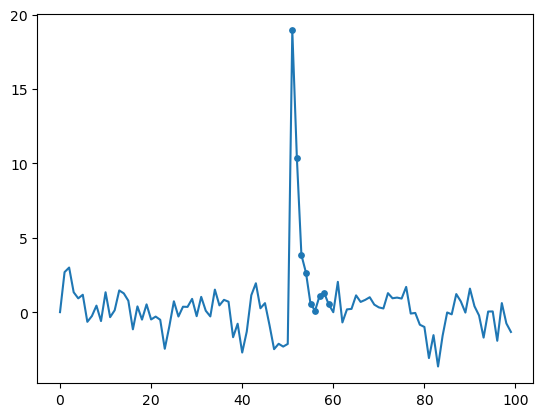

In [5]:
xs = range(100)
es = np.random.randn(100)
es[50] = 20
y = [0]
for i in range(99):
    y += [0.5*y[-1] + es[i]]

plt.plot(xs,y)
plt.scatter(xs[51:60],y[51:60], s = 15)
plt.show()

## The $\operatorname{AR}(2)$ model

An $\operatorname{AR}(2)$ model has the form:

$$
y_t = \alpha y_{t-1} + \beta y_{t-2} + \epsilon_t
$$

This can be refomulated as

$$
\begin{bmatrix}
y_t \\ y_{t-1}
\end{bmatrix}
=
\begin{bmatrix}
a & b\\
1 & 0
\end{bmatrix}
\begin{bmatrix}
y_{t-1} \\
y_{t-2}
\end{bmatrix}

+

\begin{bmatrix}
\epsilon_t \\
0
\end{bmatrix}
$$

The behavior of the impulse response can be determined by finding the eigenvectors and eigenvalues of the matrix. We need both eigenvalues to be in the unit disk of the complex plane for the difference equation to converge.

The following picture shows the impulse response functions for $\alpha,\beta \in [-2,2]$.  Red indicates divergence, black indicates convergence with real eigenvalues, and blue indicates convergence with complex eigenvalues:

In [6]:
import cmath

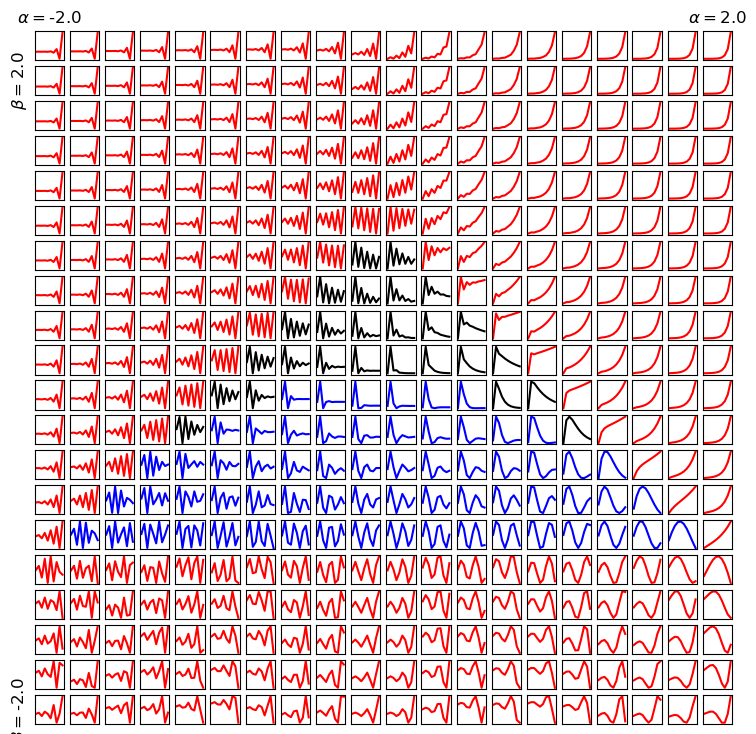

In [7]:
n = 20 # number of rows and columns
xs = range(10) # x values for each plot
nrow = n
ncol = n

fig, axs = plt.subplots(nrow, ncol, figsize=(9, 9))


for i, ax in enumerate(fig.axes):
    y = [0,1] # initialize y with 0, 1.
    a = 2*(2*(i%n)/(n-1) -1) # value of alpha between -2 and 2
    b = 2*(-(2*((i)//n)/(n-1) -1)) # value of beta between -2 and 2
    if i == 0:
        ax.set_title('$\\alpha = $' +str(a))
    if i == n-1:
        ax.set_title('$\\alpha = $' +str(a))
    if i == n:
        ax.set_ylabel('$\\beta = $'+str(np.round(b)), size='large')
    if i == n*(n-1):
        ax.set_ylabel('$\\beta = $'+str(np.round(b)), size='large')
    for j in range(8):
        y+= [a*y[-1] + b*y[-2]] # the AR recursion
    ax.set_xticks([])
    ax.set_yticks([])

    #maxmod is the maximum modulus of the eigenvalues
    maxmod =  np.max([abs(a/2.0 + 0.5*cmath.sqrt(a**2 + 4*b)), abs(a/2.0 - 0.5*cmath.sqrt(a**2 + 4*b))])

    if maxmod < 0.9999:
        if a**2 + 4*b < 0:
            ax.plot(xs, y, c='b')
        else:
            ax.plot(xs, y, c = 'k')
    else:
        ax.plot(xs, y, c = 'r')
        
plt.autoscale()
plt.show()

As we can see the complexity of the impulse responses for $\operatorname{AR}(2)$ models is vast!  We can have exponential decay or damped periodic exponential decay. 

There is a tight analogy with the damped harmonic oscillator:  the behavior is similar to a weight attached to a hanging spring with friction.  An $\operatorname{AR}(2)$ impulse response obeys a second order difference equation while the spring follows a second order differential equation.

## The $\operatorname{AR}(p)$ model

The full $\operatorname{AR}(p)$ model is 

$$
y_t = \beta_1 y_{t-1} + \beta_2 y_{t-2} + \dots  + \beta_p y_{t - p} + \epsilon_t
$$

which can be again rewritten in matrix form as 

$$
\begin{bmatrix}
y_{t}\\y_{t-1} \\ \vdots \\ y_{t-p+3} \\ y_{t-p+2}
\end{bmatrix}
=
\begin{bmatrix}
\beta_1 & \beta_2 & \dots & \beta_{p-1} & \beta_p\\
1 & 0 & \dots & 0 & 0\\
0 & 1 & \dots & 0 & 0\\
0 & 0 & \dots & 1 & 0
\end{bmatrix}
\begin{bmatrix}
y_{t-1}\\y_{t-2} \\ \vdots \\ y_{t-p+2} \\ y_{t-p+1}
\end{bmatrix}
+ 
\begin{bmatrix}
\epsilon_{t}\\0 \\ \vdots \\ 0 \\ 0
\end{bmatrix}
$$

Again, the eigenvalues $\lambda_i$ of this matrix must all be contained in the unit disk for the impulse response functions to converge.

Let's look at some simulated $AR(3)$ data:

In [8]:
import statsmodels.api as sm

In [14]:
xs = range(10000)
es = 0.1*np.random.randn(10000)
ys = list(es[:3])
for i in range(3,10000):
    ys += [0.5*ys[-1] - 0.2*ys[-2] + 0.3*ys[-3]+es[i]]

<>:1: SyntaxWarning: invalid escape sequence '\o'
<>:1: SyntaxWarning: invalid escape sequence '\o'
/var/folders/14/6_njfgsd63b_nr13v4mq3fb00000gn/T/ipykernel_8404/1292256716.py:1: SyntaxWarning: invalid escape sequence '\o'
  plt.plot(xs[-100:],ys[-100:],label = 'An $\operatorname{AR}(3)$ process')


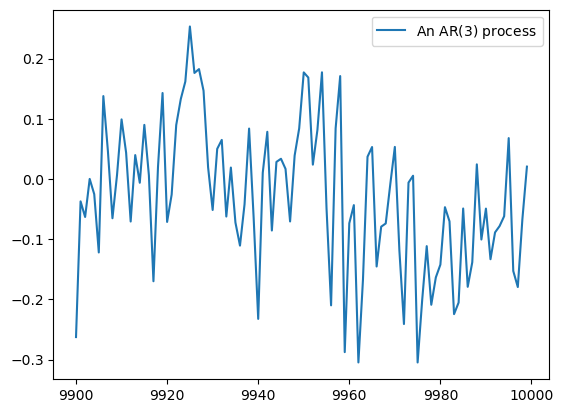

In [15]:
plt.plot(xs[-100:],ys[-100:],label = 'An $\operatorname{AR}(3)$ process')
plt.legend()
plt.show()

We can look at the autocorrelation:

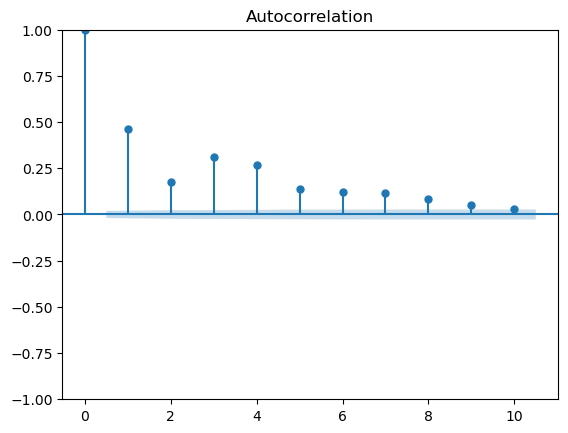

In [16]:
sm.graphics.tsa.plot_acf(ys, lags = 10)
plt.show()

Note that for an $\operatorname{AR}(p)$ process we should expect to see significant autocorrelation falling off exponentially.  This reduces the usefulness of the ACF plot for $\operatorname{AR}$ models.

### Partial Autocorrelation Function (PACF)

To address this shortcoming of the ACF we introduce the PACF.  You should think of this as an ACF plot which has been corrected so that the serial correlation has been removed: it shows the "direct impact" of a shock at time $t$ on time $t+k$, eliminating the influence it would have only through its propagation through $t+1$, $t+2$, ..., $t+k-1$.

I also recommend reading [this intuitive explanation](https://stats.stackexchange.com/a/281726) on CrossValidated.

In [28]:
# I show how to get the PACF values "by hand" here.

def design_matrix_of_lags(ts, num_lags):
    '''
    Inputs
        ts: A numpy array of size (n,) representing a time series
        num_lags: The number of lags to include in the resulting design matrix

    Outputs
        X: A numpy array of size (n - num_lags, num_lags). 
            The first column is lag 1, second column is lag 2, etc 
        y: The time series starting at entry num_lags
    '''
    n = len(ts)
    X = np.zeros(shape = (n - num_lags, num_lags))
    for i in range(num_lags):
        X[:, i] = ts[i:i + n - num_lags]
    y =  ts[num_lags:]
    return (X,y)

from sklearn.linear_model import LinearRegression

def pacf(ts, num_lags):
    '''
    Inputs: 
        ts: A numpy array of size (n,) representing a time series
        num_lags: The number of lags to include in the resulting design matrix
    Outputs:
        coefficients:  The PACF values at each of the lags.
    '''
    coefficients = []
    lr = LinearRegression()
    for i in range(num_lags): 
        lr.fit(*design_matrix_of_lags(ts, i+1))
        coefficients.append(lr.coef_[0])
    return coefficients

In [29]:
pacf(ys, 6)

[0.4626846762162331,
 -0.04538059360163155,
 0.31232252322134374,
 0.0036737660430320373,
 0.015915117939476517,
 0.003747423069388915]

In [30]:
# Here is the built in way.  I specify method = 'ols' for agreement with our hand written code.

sm.tsa.stattools.pacf(ys,  method = 'ols')[:6]

array([ 1.        ,  0.46268468, -0.04538059,  0.31232252,  0.00367377,
        0.01591512])

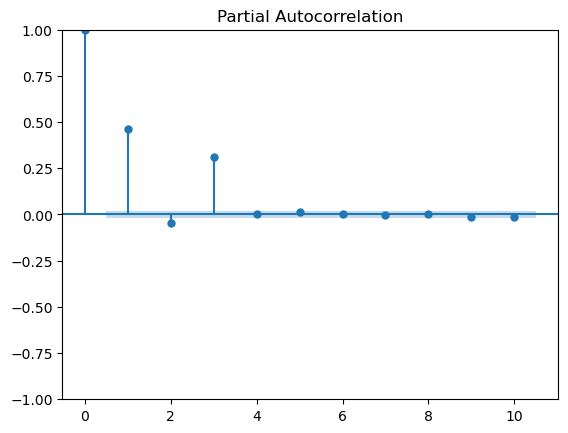

In [31]:
# This is how to make a pacf plot
sm.graphics.tsa.plot_pacf(ys, lags=10, method='ols')
plt.show()


We can decide which value of $p$ to use for an $\operatorname{AR}(p)$ process by selecting the last significant lag in the $\operatorname{PACF}$ plot.

--------------------------

This notebook was written for the Erdős Institute Data Science Boot Camp by Steven Gubkin.

Please refer to the license in this repo for information on redistribution.